In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import end2end, end2end_crps

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('mpg')

In [3]:
end2end_model = end2end_crps.train_model(x_train, y_train, calibration_threshold = .03)

initial loss:  832.55517578125
524 0.030877777777777764 tensor(2.7719, grad_fn=<MeanBackward0>) tensor(1.4308, grad_fn=<MeanBackward0>)
525 0.04294444444444446 tensor(2.7974, grad_fn=<MeanBackward0>) tensor(1.4414, grad_fn=<MeanBackward0>)
526 0.06627777777777775 tensor(2.9017, grad_fn=<MeanBackward0>) tensor(1.4721, grad_fn=<MeanBackward0>)
527 0.04812222222222224 tensor(2.7829, grad_fn=<MeanBackward0>) tensor(1.4372, grad_fn=<MeanBackward0>)
528 0.036855555555555544 tensor(2.7770, grad_fn=<MeanBackward0>) tensor(1.4271, grad_fn=<MeanBackward0>)
529 0.032400000000000005 tensor(2.7378, grad_fn=<MeanBackward0>) tensor(1.4192, grad_fn=<MeanBackward0>)
539 0.03377777777777779 tensor(2.7425, grad_fn=<MeanBackward0>) tensor(1.4161, grad_fn=<MeanBackward0>)
540 0.058133333333333294 tensor(2.8733, grad_fn=<MeanBackward0>) tensor(1.4475, grad_fn=<MeanBackward0>)
541 0.06513333333333335 tensor(2.8563, grad_fn=<MeanBackward0>) tensor(1.4459, grad_fn=<MeanBackward0>)
542 0.08032222222222218 tenso

883 0.04954444444444444 tensor(2.4540, grad_fn=<MeanBackward0>) tensor(1.2343, grad_fn=<MeanBackward0>)
884 0.037111111111111136 tensor(2.4043, grad_fn=<MeanBackward0>) tensor(1.2202, grad_fn=<MeanBackward0>)
957 0.030666666666666648 tensor(2.3447, grad_fn=<MeanBackward0>) tensor(1.1873, grad_fn=<MeanBackward0>)
958 0.06651111111111115 tensor(2.4046, grad_fn=<MeanBackward0>) tensor(1.2056, grad_fn=<MeanBackward0>)
959 0.16892222222222217 tensor(2.5481, grad_fn=<MeanBackward0>) tensor(1.2663, grad_fn=<MeanBackward0>)
960 0.2828555555555556 tensor(2.6592, grad_fn=<MeanBackward0>) tensor(1.3468, grad_fn=<MeanBackward0>)
961 0.36418888888888884 tensor(2.7531, grad_fn=<MeanBackward0>) tensor(1.4608, grad_fn=<MeanBackward0>)
962 0.2325111111111112 tensor(2.6137, grad_fn=<MeanBackward0>) tensor(1.3781, grad_fn=<MeanBackward0>)
963 0.1323666666666666 tensor(2.4774, grad_fn=<MeanBackward0>) tensor(1.2887, grad_fn=<MeanBackward0>)
964 0.059700000000000024 tensor(2.3869, grad_fn=<MeanBackward0>) 

End2end test MAPE:  0.08512881
End2end test RMSE:  2.658218
End2end test NLLK:  2.8779094
End2end test CRPS:  tensor(1.3912)


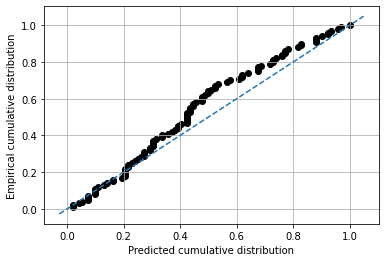

End2end test calibration error when step size is 0.001:  5.32020604914934
End2end test calibration error when step size is 0.01:  0.5247684310018906
End2end test calibration error when step size is 0.1:  0.05139413988657847


In [4]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [5]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 10%|████▎                                      | 1/10 [00:00<00:00,  9.12it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 10%|████▎                                      | 1/10 [00:00<00:01,  8.43it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  8.77it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.961
  RMSE          2.658
  MDAE          1.507
  MARPD         8.518
  R2            0.875
  Correlation   0.937
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.074
  Mean-absolute Calibration Error       0.070
  Miscalibration Area                   0.070
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.179
     Group Size: 0.56 -- Calibration Error: 0.114
     Group Size: 1.00 -- Calibration Error: 0.070
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.232
     Group Size: 0.56 -- Calibration Error: 0.114
     Group Size: 1.00 -- Calibration Error: 0.074
================

Lims is None. Setting lims now:
min_max_true: (11.0, 46.6)
min_max_pred: (11.952081, 44.52433)
lims: (11.0, 46.6)
lims_ext: (7.44000015258789, 50.1599983215332)


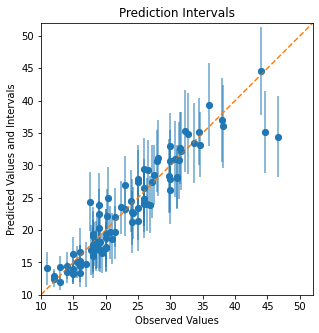

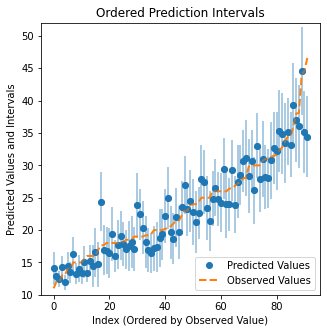

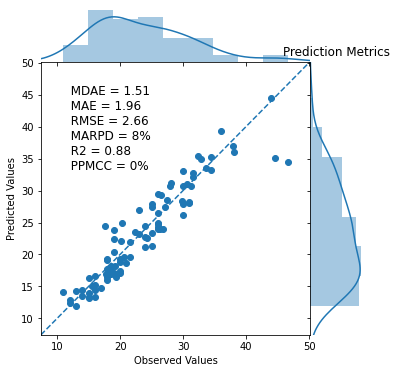

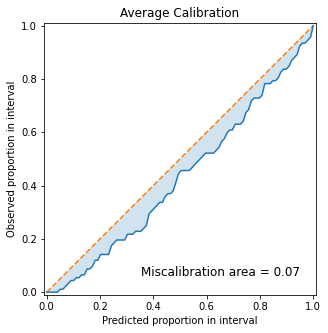

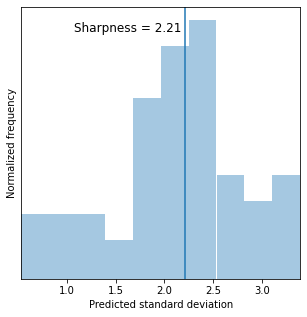

In [6]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))